In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Appliedai colab/Assignment 6 - Naive bayes on Donor\'s choose

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Appliedai colab/Assignment 6 - Naive bayes on Donor's choose


# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from google.colab import files
from tqdm import tqdm

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,  MultiLabelBinarizer, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix,  roc_auc_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
data = pd.read_csv('preprocessed_final.csv',nrows = 50000) #reading locally using pandas

# Feature Set 1 - BOW

In [0]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
#https://stackoverflow.com/a/54704747/9292995

def Donors_choose_pipe(data, model, text_transformer):
  numeric_features = ['teacher_number_of_previously_posted_projects', 'price']
  numeric_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())])

  categorical_features = ['school_state', 'teacher_prefix', 'project_grade_category','clean_categories','clean_subcategories']
  categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore'))])

  # text_features = ['essay','project_title']
  text_transformer = Pipeline(steps=[
      ('trans', text_transformer)])

  preprocessor = ColumnTransformer(
      transformers=[('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features),
          ('essay', text_transformer, "essay"),
          ('title', text_transformer, "project_title")]
      ,n_jobs=-1, verbose=True, remainder = 'passthrough'
              )

  # Append classifier to preprocessing pipeline.
  # Now we have a full prediction pipeline.
  pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier',  model)])

  y = data['project_is_approved'].values
  X = data.drop(['project_is_approved'], axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state = 42)

  pipeline.fit(X_train, y_train)
  print("model score: %.3f" % pipeline.score(X_test, y_test))
  return pipeline, X, y, X_train, X_test, y_train, y_test

In [0]:
def searchplot(rs, alpha, title):
  print(("best from search: %.3f"
        % rs.score(X_test, y_test)))

  results = pd.DataFrame.from_dict(rs.cv_results_)

  results = results.sort_values(alpha)
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']

  K =  results[alpha]

  plt.plot(K, train_auc, label='Train AUC')
  # https://stackoverflow.com/a/48803361/4084039
  # plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

  plt.plot(K, cv_auc, label='CV AUC')

  plt.scatter(K, train_auc, label='Train AUC points')
  plt.scatter(K, cv_auc, label='CV AUC points')


  plt.legend()
  plt.xscale('log')
  plt.xlabel("Alpha")
  plt.ylabel("AUC")
  plt.title(title)
  plt.grid()
  plt.show()

  results.head()

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

def roc_auc_pipe(clf, X_train, X_test, y_train, y_test, title):
  y_train_pred = clf.predict_proba(X_train)[:,1]
  y_test_pred = clf.predict_proba(X_test)[:,1]
      
  train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
  test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

  plt.close
  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1],'g--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  plt.title(title)
  plt.grid()
  plt.show()


#really good ROCAUC plot

# plt.figure()
# lw = 2
# plt.plot(fpr[0], tpr[0], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [0]:
%%time
text_transformer = CountVectorizer(min_df=10,ngram_range=(1,4))
model = MultinomialNB()
clf, X, y, X_train, X_test, y_train, y_test = Donors_choose_pipe(data, model, text_transformer)

model score: 0.775
CPU times: user 41.4 s, sys: 2.25 s, total: 43.7 s
Wall time: 2min 44s


In [0]:
print("model score: %.3f" % clf.score(X_train, y_train))

model score: 0.883


In [0]:
%%time
param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
#adding n_jobs = -1 causes memory leaks
rs = GridSearchCV(clf, param_grid, cv = 3, n_jobs = -1, iid=False, verbose=5, return_train_score = True, scoring = "roc_auc")

rs.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 10.4min finished


CPU times: user 7.89 s, sys: 1.23 s, total: 9.11 s
Wall time: 12min 19s


best from search: 0.700


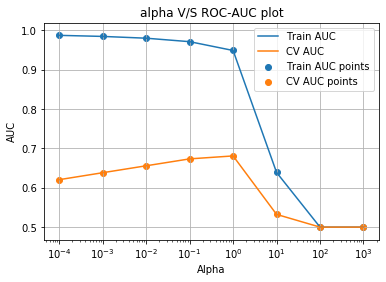

In [0]:
searchplot(rs, alpha = 'param_classifier__alpha', title = 'alpha V/S ROC-AUC plot')

The best hyper parameter which seems to give the highest and best AUC is c = 0.1

In [0]:
y_pred = cross_val_predict(clf, X_test, y_test, cv=3)
conf_mat = confusion_matrix(y_test, y_pred)

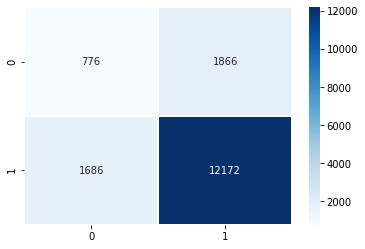

In [0]:
sns.heatmap(conf_mat,  annot=True,  cmap = 'Blues', fmt = 'g', linewidths=.5);

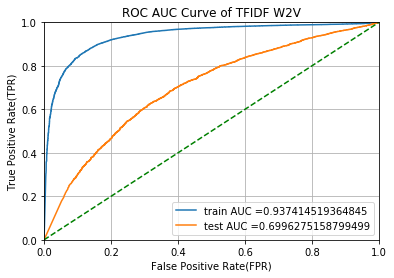

In [0]:
#Trained on Best hyperparameter alpha = 0.1
roc_auc_pipe(clf, X_train, X_test, y_train, y_test, "ROC AUC Curve BOW (best hyperparameter)")

# Feature Set 2 - TFIDF

In [0]:
%%time
text_transformer = TfidfVectorizer(stop_words = 'english', min_df = 10)
model = MultinomialNB()
clf, X, y, X_train, X_test, y_train, y_test = Donors_choose_pipe(data, model, text_transformer)

model score: 0.836
CPU times: user 1.49 s, sys: 352 ms, total: 1.84 s
Wall time: 10.8 s


In [0]:
print("model score: %.3f" % clf.score(X_train, y_train))

model score: 0.843


In [0]:
%%time
param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
#adding n_jobs = -1 causes memory leaks
rs = RandomizedSearchCV(clf, param_grid, cv = 2, n_jobs = -1, iid=False, verbose=5, return_train_score = True, scoring = "roc_auc")

rs.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.5min finished


CPU times: user 3.82 s, sys: 738 ms, total: 4.56 s
Wall time: 1min 38s


In [0]:
rs.best_params_

{'classifier__alpha': 0.1}

best from search: 0.636


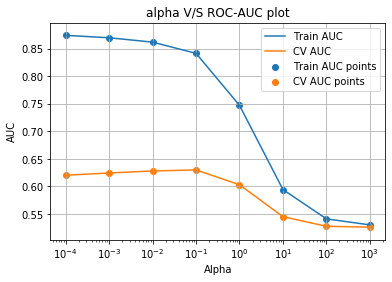

In [0]:
searchplot(rs, alpha = 'param_classifier__alpha', title = 'alpha V/S ROC-AUC plot')

In [0]:
y_pred = cross_val_predict(clf, X_test, y_test, cv=3)
conf_mat = confusion_matrix(y_test, y_pred)

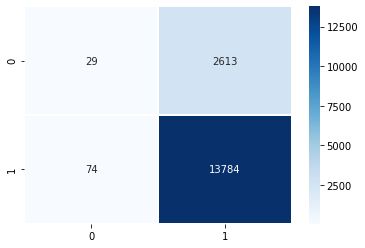

In [0]:
sns.heatmap(conf_mat,  annot=True, cmap = 'Blues', fmt = 'g', linewidths=.5);

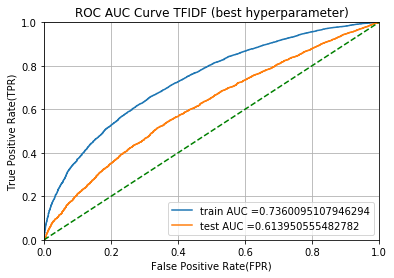

In [0]:
roc_auc_pipe(clf, X_train, X_test, y_train, y_test, "ROC AUC Curve TFIDF (best hyperparameter)")

In [0]:
#Source - https://stackoverflow.com/a/26980472/9292995

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=20):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(abs(classifier.named_steps['classifier'].feature_log_prob_[0]), feature_names))[:n]
    topn_class2 = sorted(zip(abs(classifier.named_steps['classifier'].coef_[0]), feature_names))[-n:]
    print("Top 20 features for class 0")
    print("")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print('='*50)   
    print("Top 20 features for class 1")
    print("")
    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)

In [0]:
cat = list(clf.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names())
essay = clf.named_steps['preprocessor'].transformers_[2][1].named_steps['trans'].get_feature_names()
title = clf.named_steps['preprocessor'].transformers_[3][1].named_steps['trans'].get_feature_names()

In [0]:
vocab = essay+title

In [0]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(vocab)

<11570x10117 sparse matrix of type '<class 'numpy.int64'>'
	with 11570 stored elements in Compressed Sparse Row format>

In [0]:
most_informative_feature_for_binary_classification(vectorizer, clf)

Top 20 features for class 0

0 3.502622581265718 21
0 3.7024398783219157 25
0 3.8376322947743198 21st
0 3.954137374985211 23
0 4.445987097292196 37
0 4.565651601048286 40
0 4.660008845209531 24
0 4.799712582060969 101
0 4.808491199969404 throws
0 4.892215461044274 2nd
0 4.962152768301094 3d
0 5.139134277852142 240
0 5.150476554456076 20th
0 5.219333639399266 2010
0 5.5104159191392155 aesthetic
0 5.518623899557046 aerobic
0 5.557844612710327 115
0 5.679205469714594 afternoon
0 5.763288586925135 19
0 5.764148312637719 socioeconomics
Top 20 features for class 1

1 12.970663743541014 aimed
1 12.970663743541014 agility
1 12.970663743541014 advocating
1 12.970663743541014 advocate
1 12.970663743541014 adaptations
1 12.970663743541014 acting
1 12.970663743541014 acrylic
1 12.970663743541014 78
1 12.970663743541014 48
1 12.970663743541014 365
1 12.57054020945108 memorizing
1 12.556268780844576 revisions
1 12.466155123344047 resounding
1 12.461319211124971 behaviorally
1 12.437202264012127 demo

In [0]:
from prettytable import PrettyTable
t = PrettyTable(['Vectorizer', 'Model','Hyperparameter','AUC'])
t.add_row(['BOW', 'Brute', 0.1, 0.699])
t.add_row(['TFIDF', 'Brute', 0.1, 0.613])
print(t)

+------------+-------+----------------+-------+
| Vectorizer | Model | Hyperparameter |  AUC  |
+------------+-------+----------------+-------+
|    BOW     | Brute |      0.1       | 0.699 |
|   TFIDF    | Brute |      0.1       | 0.613 |
+------------+-------+----------------+-------+
